In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
fullDF = pd.read_csv('nsch_2016_topical.csv')
print(fullDF.columns)

Index(['FIPSST', 'HHID', 'FORMTYPE', 'TOTKIDS_R', 'HHLANGUAGE', 'SC_AGE_YEARS',
       'SC_SEX', 'K2Q35A_1_YEARS', 'MOMAGE', 'K6Q41R_STILL',
       ...
       'BIRTHWT', 'CBSAFP_YN', 'FWC', 'CURRINS', 'INSTYPE', 'HOUSE_GEN',
       'HHSIZE_I', 'HHSIZE_IF', 'FPL_IF', 'INSGAP'],
      dtype='object', length=422)


## The Model ##

Consider two sequential ages, say 6 and 7 years.  Given an child at one age, the goal is to produce a *guide function* which can be used to select a collection of children at the other age which as a group describe the most likely match to the original child.  Specifically, given a sample of individuals at one age, the guide function should generate samples at the other age having the highest possible *mutual information* with the first group.

The guided samples will be selected by applying *Metropolis sampling* using the guide function.  This requires only that the guide function be positive definite and integrable.  In essense the guide function is proportional to the likelihood that a sampled child at one age matches a specific child at the other age.

We will develop an appropriate guide function by defining a function of an appropriate form in terms of a set of weights.  Samples will be drawn based on the given weights, the mutual information will be calculated, and the weights will be updated so as to increase the mutual information.  This process will be repeated until the mutual information is maximized.  The set of weights which produces the maximum mutual information is the optimal choice of weights given the initial choice of form for the guide function.

## The Model ##

Consider a child of some given age, say 6 years old, and some definite current state in terms of the other factors that we are considering.  The goal is, based on this current state, to select a plausible future state for this child at age seven.

This is accomplished through the use of a *guide function* which can be used to select a collection of children at the other age which as a group describe the most likely match to the original child.  Specifically, given a sample of individuals at one age, the guide function should generate samples for the next simulated age having the highest possible *mutual information* with the first group.

The guided samples will be selected by applying *Metropolis sampling* using the guide function.  This requires only that the guide function be positive definite and integrable.  In essense the guide function is proportional to the likelihood that a sampled child at one age matches a specific child at some other age.

We will develop an appropriate guide function by defining a function of an appropriate form in terms of a set of weights.  Samples will be drawn based on the given weights, the mutual information will be calculated, and the weights will be updated so as to increase the mutual information.  This process will be repeated until the mutual information is maximized.  The set of weights which produces the maximum mutual information is the optimal choice of weights given the initial choice of form for the guide function.

This process will be repeated for each definte state that is encountered during the course of simulation.  Since many of the *possible* states will be very *improbable*, we will not generate and optimized guide function for every possible state; rather, the necessary guide functions will be generated on-the-fly, as needed.  The guide function corresponding to each unique state that the simulation encounters will be memoized, allowing for repeated retrieval without additional computation.  Since we will repeatedly encounter, throughout the simulation, states that are *similar but identical* to states that have already been encountered, we will use the guide function of the most similar state found thusfar as the starting point for the selection of the required guide function by maximizing the mutual information as described previously. 



## Factors we are using ##
* ACE7: experienced violence
* ACE8: drugs and alcohol
* SC_AGE_YEARS: selected child age
* K4Q32X01: vision tested by eye doctor (2.0 -> False)
* K7Q30: sports teams
* K7Q31: clubs or organizations
* FPL: percent of federal poverty level?
* AGEPOS4: birth order
* FWC: sample weight
* YEAR: survey year

In [3]:
subDF=fullDF[['ACE7', 'ACE8', 'FWC', 'YEAR', 'FPL', 'SC_AGE_YEARS','K4Q32X01', 'K7Q30', 'K7Q31', 'AGEPOS4']]
subDF = subDF.dropna()
print(len(subDF))
#print subDF

28084


In [4]:
age6DF = subDF[subDF.SC_AGE_YEARS==6]
print(len(age6DF))
age7DF = subDF[subDF.SC_AGE_YEARS==7]
print(len(age7DF))

1768
1872


Select samples from the table in a weighted fashion

In [5]:
def mkSamps(df, nSamp):
    fracWt = df['FWC']/df['FWC'].sum()
    choices = np.random.choice(len(df), nSamp, p=fracWt)
    return df.iloc[choices].drop(columns=['FWC'])
nSamp = 10
print(mkSamps(age6DF, nSamp))


       ACE7  ACE8    YEAR    FPL  SC_AGE_YEARS  K4Q32X01  K7Q30  K7Q31  \
24797   2.0   2.0  2016.0  400.0           6.0       1.0    1.0    1.0   
47181   2.0   2.0  2016.0  123.0           6.0       1.0    2.0    2.0   
17045   2.0   2.0  2016.0  151.0           6.0       2.0    2.0    2.0   
3431    2.0   2.0  2016.0   50.0           6.0       1.0    2.0    2.0   
22804   2.0   2.0  2016.0  216.0           6.0       2.0    2.0    2.0   
16983   1.0   1.0  2016.0  226.0           6.0       2.0    2.0    2.0   
32499   2.0   2.0  2016.0  102.0           6.0       2.0    2.0    2.0   
17540   2.0   2.0  2016.0  262.0           6.0       2.0    2.0    2.0   
18324   2.0   2.0  2016.0  400.0           6.0       2.0    1.0    1.0   
34850   2.0   1.0  2016.0  400.0           6.0       2.0    1.0    1.0   

       AGEPOS4  
24797      3.0  
47181      5.0  
17045      4.0  
3431       3.0  
22804      3.0  
16983      5.0  
32499      2.0  
17540      1.0  
18324      4.0  
34850      1.0 

In [6]:
COLUMN_DICT = {key : idx for idx, key in enumerate(mkSamps(subDF, 1).columns)}
print(COLUMN_DICT)

{'ACE7': 0, 'ACE8': 1, 'YEAR': 2, 'FPL': 3, 'SC_AGE_YEARS': 4, 'K4Q32X01': 5, 'K7Q30': 6, 'K7Q31': 7, 'AGEPOS4': 8}


FPL needs to be binned to form a histogram to get the quantization we need for this.  Bins of 50 seems OK.

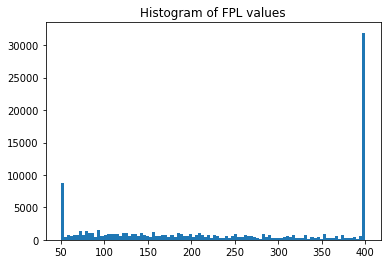

In [7]:
fplSamps = mkSamps(subDF, 100000)['FPL']
plt.hist(fplSamps, bins=100)
plt.title('Histogram of FPL values')
plt.show()

We need to enumerate the possible states for our variables.  Assume fixed age and ignore the ACE components for the moment.  

In [8]:
def whichBin(sampV):
    """
    Input is an ndarray of sample values
    """
    fplBinWidth = 50
    fplMin = 50
    bin = np.abs((sampV[:, COLUMN_DICT['FPL']] - fplMin) // 50).astype('int')
    assert (bin >= 0).all() and (bin < 8).all(), 'FPL out of range?'
    nBins = 8
    # Each of the following is either 1.0 or 2.0
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K4Q32X01']] == 1.0)
    nBins *= 2
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K7Q30']] == 1.0)
    nBins *= 2
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K7Q31']] == 1.0)
    nBins *= 2
    return bin, nBins

def scatter(idx, vals, target):
    """target[idx] += vals, but allowing for repeats in idx"""
    np.add.at(target, idx.ravel(), vals.ravel())


In [9]:
def toHisto(sampV):
    """Generate a histogram of sample bins"""
    binV, nBins = whichBin(sampV)
    targ = np.zeros([nBins], dtype=np.int32)
    vals = np.ones([len(sampV)], dtype=np.int32)
    scatter(binV, vals, targ)
    return targ

In [10]:
def toProbV(sampV):
    sampH = toHisto(sampV)
    probV = sampH.astype(np.float64)
    probV /= np.sum(probV)
    return probV

In [11]:
sampV = mkSamps(subDF, 1000)
print(sampV.columns)
print(COLUMN_DICT['FPL'])
sampH = toHisto(sampV.values)
print(sampH)
probV = toProbV(sampV.values)
print(probV)

Index(['ACE7', 'ACE8', 'YEAR', 'FPL', 'SC_AGE_YEARS', 'K4Q32X01', 'K7Q30',
       'K7Q31', 'AGEPOS4'],
      dtype='object')
3
[42  7 14 19 53 14 19 38 15  7  1  8 33 13 11 16  8  8 12  8 18  8 10 27
 11  8  6 12 11 15 11 12  5  4  4 11 14  4  9 27  6  3  5 13 10  4  7 21
  6  2  6  9  4  5  7 21 13  8 31 80 23 18 30 95]
[0.042 0.007 0.014 0.019 0.053 0.014 0.019 0.038 0.015 0.007 0.001 0.008
 0.033 0.013 0.011 0.016 0.008 0.008 0.012 0.008 0.018 0.008 0.01  0.027
 0.011 0.008 0.006 0.012 0.011 0.015 0.011 0.012 0.005 0.004 0.004 0.011
 0.014 0.004 0.009 0.027 0.006 0.003 0.005 0.013 0.01  0.004 0.007 0.021
 0.006 0.002 0.006 0.009 0.004 0.005 0.007 0.021 0.013 0.008 0.031 0.08
 0.023 0.018 0.03  0.095]


Given the probV we can calculate mutual information:
$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X} p(x, y) log \left (\frac{p(x,y)}{p(x)p(y)} \right )
$$

In [12]:
def mutualInfo(sampVX, sampVY):
    assert len(sampVX) == len(sampVY), 'Sample vector lengths do not match'
    binVX, nBinsX = whichBin(sampVX)
    binVY, nBinsY = whichBin(sampVY)
    assert nBinsX == nBinsY, 'Unexpectedly got different bin counts?'
    cA = np.zeros([nBinsX, nBinsX], dtype=np.int32)
    idxV = np.ravel_multi_index(np.array([binVX, binVY]), (nBinsX, nBinsX))
    np.add.at(cA.ravel(), idxV, np.ones(len(idxV), dtype=np.int32).ravel())
    pA = cA.astype(np.float32)
    pA /= sum(pA.ravel())
    xPV = toProbV(sampVX)
    yPV = toProbV(sampVY)
    xyPA = np.einsum('i,j->ij', xPV, yPV)  # einsum is my new favorite function
    oldErr = np.seterr(invalid='ignore', divide='ignore')
    prodA = pA * np.nan_to_num(np.log(pA / xyPA))  # element-wise calculation
    np.seterr(**oldErr)
    return np.sum(prodA.ravel())

sampX = mkSamps(subDF, 3000)
sampY = mkSamps(subDF, 3000)
print(mutualInfo(sampX.values, sampY.values))
print(mutualInfo(sampX.values, sampX.values))
print(mutualInfo(sampY.values, sampY.values))

0.5582311801423269
3.7734557133672215
3.8092558065553765


In [13]:
########
# This implementation (from stackoverflow) produces the same MI values as the one above
# stackoverflow.com/questions/20491028/optimal-way-to-compute-pairwise-mutual-information-using-numpy
########
#from scipy.stats import chi2_contingency
#
#def calc_MI(x, y, bins):
#    c_xy = np.histogram2d(x, y, bins)[0]
#    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood")
#    mi = 0.5 * g / c_xy.sum()
#    return mi
#
#def mutualInfo(sampVX, sampVY):
#    assert len(sampVX) == len(sampVY), 'Sample vector lengths do not match'
#    binVX, nBinsX = whichBin(sampVX)
#    binVY, nBinsY = whichBin(sampVY)
#    assert nBinsX == nBinsY, 'Unexpectedly got different bin counts?'
#    return calc_MI(binVX, binVY, nBinsX)
#
#print mutualInfo(sampX.values, sampY.values)
#print mutualInfo(sampX.values, sampX.values)
#print mutualInfo(sampY.values, sampY.values)

Define a scalar function on a pair of samples and a weight vector

In [14]:
wtSer = pd.Series({'YEAR': 1.0,
                   'FPL':1.0e-4,  # because it's percent
                   'SC_AGE_YEARS': 1.0, 
                   'K4Q01': 1.0, 
                   'K4Q32X01': 1.0,
                   'K7Q30':1.0,
                   'K7Q31': 1.0,
                   'AGEPOS4': 1.0}, index=subDF.columns)
wtSer = wtSer.drop(labels=['ACE7', 'ACE8', 'FWC'])  # get the right index order but no extra entries
print(wtSer)
print(wtSer.values)
print(wtSer.index)

YEAR            1.0000
FPL             0.0001
SC_AGE_YEARS    1.0000
K4Q32X01        1.0000
K7Q30           1.0000
K7Q31           1.0000
AGEPOS4         1.0000
dtype: float64
[1.e+00 1.e-04 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00]
Index(['YEAR', 'FPL', 'SC_AGE_YEARS', 'K4Q32X01', 'K7Q30', 'K7Q31', 'AGEPOS4'], dtype='object')


In [15]:
def funV(samps1V, samps2V, wtSerV):
    """
    Returns a numpy vector the columns of which correspond to the input samples
    """
    wtA = wtSerV
    #print wtA.shape
    #print samps1V.shape
    offset = samps1V.shape[1] - wtSerV.shape[0]
    #print offset
    samp1A = samps1V[:, offset:]
    samp2A = samps2V[:, offset:]
    delta = samp1A - samp2A
    print('delta', delta)
    delta *= delta
    print('delta^2', delta)
    return np.exp(-np.asmatrix(wtA) * np.asmatrix(delta).transpose())
    

In [16]:
def lnLik(samps1V, samps2V, wtSerV):
    """
    funV has the right shape to fill the role of likelihood in the Metropolis algorithm.  We'll
    take the log, and use it as a log likelihood.
    """
    wtA = wtSerV
    offset = samps1V.shape[1] - wtSer.shape[0]
    samp1A = samps1V[:, offset:]
    samp2A = samps2V[:, offset:]
    delta = samp1A - samp2A
    delta *= delta
    return np.asarray((-np.asmatrix(wtA) * np.asmatrix(delta).transpose())).reshape((-1, 1))
    

In [17]:
print(funV(mkSamps(subDF, 3).values, mkSamps(subDF, 3).values, wtSer))
llk = lnLik(mkSamps(subDF, 3).values, mkSamps(subDF, 3).values, wtSer)
print(llk)

delta [[   0. -177.   -8.    1.    1.    0.    0.]
 [   0.  -50.   -5.    1.    0.    0.    1.]
 [   0.  -76.    1.    0.    0.    0.   -1.]]
delta^2 [[0.0000e+00 3.1329e+04 6.4000e+01 1.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00]
 [0.0000e+00 2.5000e+03 2.5000e+01 1.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00]
 [0.0000e+00 5.7760e+03 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00]]
[[9.46156576e-31 1.46377851e-12 7.59560800e-02]]
[[-44.9696]
 [-39.8241]
 [ -3.0164]]


In [18]:
# Now we need a mutator
def mutate(sampV, df, stepSzV):
    """
    Return a 'mutated' version of sampV, based on the given step sizes.  Unfortunately our samples
    are discrete and come from a table, so I'm not sure how to do this unless we first generate
    a proximity network of some sort, so for the moment let's just generate a new set of samples-
    this corresponds to an infinitely wide mutator.
    """
    return mkSamps(df, len(sampV)).values

In [19]:
# And now we can write the Metropolis code.
# Thanks to https://python4mpia.github.io/fitting_data/Metropolis-Hastings.html
# initial guess for alpha as array.

nSamp = 10000
testSamps = mkSamps(age6DF, nSamp)
guess = mkSamps(age7DF, nSamp)
# Prepare storing MCMC chain as array of arrays.
A = [guess.values]
# define stepsize of MCMC.
stepsizes = np.empty([nSamp])
stepsizes.fill(0.005)
nIter = 10000

0: 0.19375751811601857
100: 0.18404834639407963
200: 0.19142998761571073
300: 0.18803394949779498
400: 0.18731330861812368
500: 0.1883033029176287
600: 0.1905741089850333
700: 0.18112849455094215
800: 0.18629016113084618
900: 0.18748810494597545
1000: 0.18648543086816494
1100: 0.18426773518245187
1200: 0.18802909706986093
1300: 0.18657734342923704
1400: 0.18837375852142552
1500: 0.18135614683573908
1600: 0.19110381083973005
1700: 0.18849245278306562
1800: 0.18652604701512937
1900: 0.1804435403968858
2000: 0.18815835020216978
2100: 0.18486453581484516
2200: 0.1864798408267758
2300: 0.18848890825438513
2400: 0.18921799037081877
2500: 0.1820595190401686
2600: 0.18501229723780138
2700: 0.18357669366481416
2800: 0.18956030541590152
2900: 0.1883906064603797
3000: 0.19073620905673624
3100: 0.1896881622949056
3200: 0.18800417183905527
3300: 0.18760720074767326
3400: 0.1899107798022276
3500: 0.18819268354493038
3600: 0.18420331737013693
3700: 0.18505937782719845
3800: 0.19133086611595757
3900: 

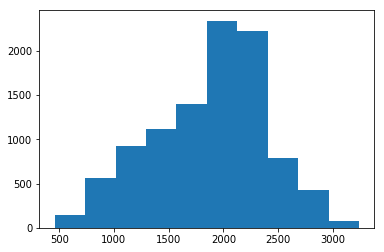

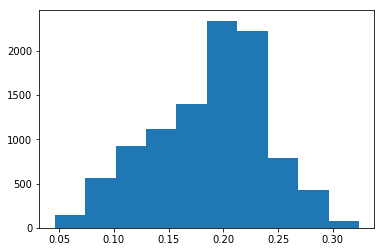

In [20]:
# Metropolis-Hastings with nIter iterations.
accepted  = np.zeros([nSamp, 1], dtype=np.int)
onesV = np.ones([nSamp], dtype=np.int).reshape((-1, 1))
zerosV = np.zeros([nSamp], dtype=np.int).reshape((-1, 1))
for n in range(nIter):
    oldAlpha  = A[-1]  # old parameter value as array
    oldLnLik = lnLik(testSamps.values, oldAlpha, wtSer)
    newAlpha = mutate(oldAlpha, age7DF, stepsizes)
    newLnLik = lnLik(testSamps.values, newAlpha, wtSer)
    if (n % 100 == 0):
        print('%s: %s' % (n, mutualInfo(testSamps.values, newAlpha)))
    choices = np.logical_or(newLnLik > oldLnLik,
                            np.random.random(newLnLik.shape) < np.exp(newLnLik - oldLnLik))
    rslt = np.choose(choices, [oldAlpha, newAlpha])
    A.append(rslt)
    accepted += np.choose(choices, [zerosV, onesV])

plt.hist(accepted)
acceptanceRate = accepted/float(nIter)
plt.show()
plt.hist(acceptanceRate)
plt.show()

In [22]:
nKeep = accepted.min()/10  # 10 mutations between samples to avoid correlation
keepStep = nIter//nKeep
burnIn = int(10 * keepStep)
print(nKeep, keepStep, burnIn)
assert burnIn < nIter, 'Not enough iterations for burn-in'
clean = []
for idx, sV in enumerate(A[burnIn:]):
    if idx % keepStep == 0:
        clean.append(sV)


45.9 217.0 2170


In [23]:
cleanV = np.concatenate(clean)
expandedTestV = np.concatenate([testSamps.values] * len(clean))

In [26]:
#print expandedTestV
print(mutualInfo(expandedTestV, cleanV))
print(mutualInfo(expandedTestV, mkSamps(age7DF, cleanV.shape[0]).values))
print(mutualInfo(expandedTestV, expandedTestV))
print(mutualInfo(cleanV, cleanV))

0.9470640137874424
0.00543064274186824
3.676647479258108
3.650408534849724


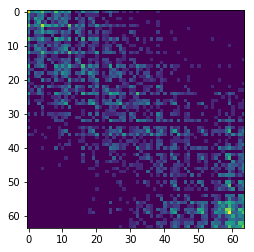

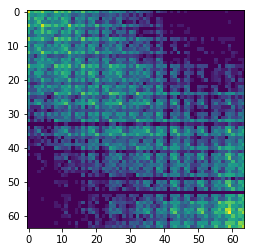

In [27]:
testBins, nBins = whichBin(testSamps.values)
rsltBins = whichBin(clean[10])[0]
hM, xEdges, yEdges = np.histogram2d(testBins, rsltBins, bins=64)
plt.imshow(np.log(hM + 1))
plt.show()

testBins, nBins = whichBin(expandedTestV)
rsltBins = whichBin(cleanV)[0]
hM, xEdges, yEdges = np.histogram2d(testBins, rsltBins, bins=64)
plt.imshow(np.log(hM + 1))
plt.show()


## Ignore the rest of this ##
These bits are just left-overs

In [ ]:
wtDF = pd.DataFrame({'FPL':[1.0, 1.0], 'SC_AGE_YEARS': [1.0, 1.0], 'K4Q01': [1.0, 1.0], 'K4Q32X01': [1.0, 1.0],
       'K7Q30':[1.0, 1.0], 'K7Q31': [1.0, 1.0], 'AGEPOS4': [1.0, 1.0]}, index=['ACE7', 'ACE8'])
print(wtDF)

In [ ]:
def funV(samps1, samps2, wtDF):
    """
    Returns a numpy matrix the rows of which correspond to ACE7 and ACE8 and
    the columns of which correspond to the input samples
    """
    wtA = wtDF.values
    offset = samps1.values.shape[1] - wtDF.values.shape[1]
    samp1A = samps1.values[:, offset:]
    samp2A = samps2.values[:, offset:]
    delta = samp1A - samp2A
    return np.asmatrix(wtA) * np.asmatrix(delta).transpose()
    

In [ ]:
print(funV(mkSamps(subDF, 3), mkSamps(subDF, 3), wtDF))

$\mathcal L(\{M_1,M_2,\ldots,M_N\};\alpha) = \prod_{n=1}^N p(M_n|\alpha) = \prod_{n=1}^N c\left(\frac{M_n}{M_\odot}\right)^{-\alpha}$